Goal: visualize the impact of trees and depth on out of sample scores

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.datasets import load_iris
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pickle

In [2]:
data = pd.read_csv("../Old/18Q1 Lending Club/accepted2017_clean.csv", encoding="ISO-8859-1")
display(data.shape)
display(data.columns)

(276848, 79)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
     

In [3]:
np.sum(data.isna()).sort_values(ascending=True)

loan_amnt              0
num_rev_tl_bal_gt_0    0
num_rev_accts          0
num_op_rev_tl          0
num_il_tl              0
                      ..
total_pymnt            0
out_prncp              0
total_acc              0
last_pymnt_d           0
install_annual         0
Length: 79, dtype: int64

In [4]:
features = ['loan_amnt','int_rate','grade','emp_length','home_ownership','annual_inc','verification_status',
           'purpose','dti','total_rev_hi_lim',
            'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util',
            'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct']

display(data.loan_status.value_counts())
# Let's sample for 2000 observations

def get_data(negative=2100, positive=300):
    data_current = data.loc[np.isin(data.loan_status,['Current']), 
                           features +['loan_status']].sample(n=2000, random_state=0)
    data_default = data.loc[np.isin(data.loan_status,['Charged Off']), 
                           features +['loan_status']].sample(n=200, random_state=0)

    data_subset = data_current.append(data_default)
    return data_subset

data_subset = get_data()
display(data_subset.loan_status.value_counts())

Current               243239
Fully Paid             24026
Late (31-120 days)      3914
In Grace Period         2239
Charged Off             2161
Late (16-30 days)       1267
Default                    2
Name: loan_status, dtype: int64

Current        2000
Charged Off     500
Name: loan_status, dtype: int64

In [5]:
data_subset = data_current.append(data_default)
data_subset.reset_index(inplace=True)

y = np.where(data_subset.loan_status == 'Charged Off', 1, 0)
data_subset.drop(columns=['loan_status'], axis=1, inplace=True)

for this_col in features:
    if data_subset[this_col].dtype == object:
        tmp = pd.get_dummies(data_subset[this_col],drop_first=True)
        data_subset = pd.concat([data_subset.drop(columns=[this_col], axis=1), tmp], axis=1)
display(data_subset.shape)
X = data_subset

(2500, 34)

In [14]:
data_subset.head().T

,0,1,2,3,4
index,236941.00,99080.00,127198.00,131595.00,271768.00
loan_amnt,19200.00,9000.00,13200.00,31500.00,7350.00
int_rate,15.05,8.24,13.99,23.99,30.17
emp_length,10.00,2.00,1.00,10.00,2.00
annual_inc,67000.00,85000.00,43000.00,68500.00,23000.00
dti,34.41,15.37,12.34,34.96,31.93
total_rev_hi_lim,69000.00,10500.00,14500.00,74300.00,11900.00
acc_open_past_24mths,7.00,3.00,1.00,6.00,2.00
bc_open_to_buy,23187.00,2618.00,503.00,15337.00,1948.00
bc_util,41.90,75.10,95.40,69.70,82.50


In [13]:
X.columns[X.dtypes == 'object']

Index([], dtype='object')

In [18]:
# TO DO: incorporate threshold
# https://stackoverflow.com/questions/61965700/adjust-threshold-cros-val-score-sklearn

In [30]:
start= time.time()
num_trees_range = [25, 100,200,300,400,500, 1000,1500]
depth_range = [5,8,10,15,20]

final_res = {}
for this_depth in depth_range:
    final_res[this_depth] = []
    for this_num in num_trees_range:
        clf = RandomForestClassifier(max_depth=this_depth, n_estimators=this_num, n_jobs=-1,
                                    class_weight='balanced')
        this_score = np.mean(cross_val_score(clf, X, y=y, cv=5, scoring='f1'))
        final_res[this_depth].append(this_score)
        print("Done with depth {} and num {}".format(this_depth, this_num))
end = time.time()

with open('./output_20Q3/clf_res_1.p','wb') as out_file:
    pickle.dump(final_res, out_file)
print("Runtime: {}".format((end - start)/ 60))



Done with depth 5 and num 25
Done with depth 5 and num 100
Done with depth 5 and num 200
Done with depth 5 and num 300
Done with depth 5 and num 400
Done with depth 5 and num 500
Done with depth 5 and num 1000
Done with depth 5 and num 1500
Done with depth 8 and num 25
Done with depth 8 and num 100
Done with depth 8 and num 200
Done with depth 8 and num 300
Done with depth 8 and num 400
Done with depth 8 and num 500
Done with depth 8 and num 1000
Done with depth 8 and num 1500
Done with depth 10 and num 25
Done with depth 10 and num 100
Done with depth 10 and num 200
Done with depth 10 and num 300
Done with depth 10 and num 400
Done with depth 10 and num 500
Done with depth 10 and num 1000
Done with depth 10 and num 1500
Done with depth 15 and num 25
Done with depth 15 and num 100
Done with depth 15 and num 200
Done with depth 15 and num 300
Done with depth 15 and num 400
Done with depth 15 and num 500
Done with depth 15 and num 1000
Done with depth 15 and num 1500
Done with depth 20 a

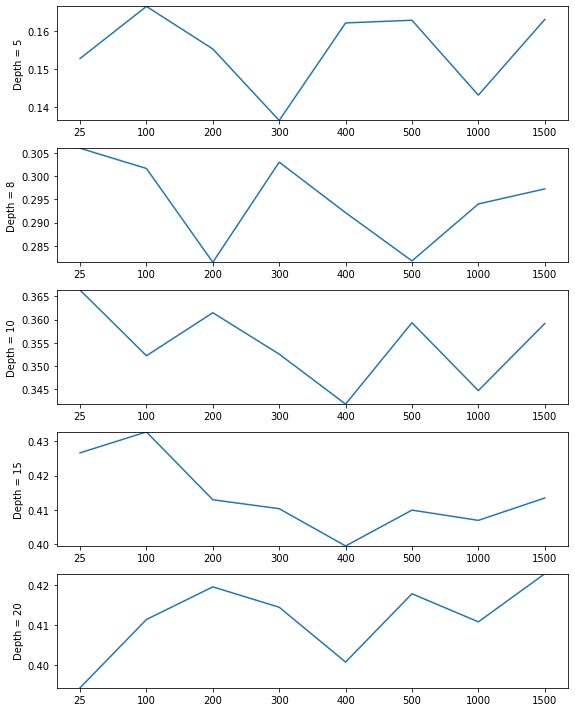

In [52]:
fig, axs = plt.subplots(figsize=(8,10), nrows=len(depth_range), ncols=1)
for this_index, this_key in enumerate(final_res.keys()):
    this_ax = axs[this_index]
    this_val = final_res[this_key]
    this_ax.plot(this_val)
    this_ax.set_xticks(ticks=range(len(this_val)))
    this_ax.set_xticklabels(labels=num_trees_range)
    this_ax.set_ylim((np.min(this_val), np.max(this_val)))
    
    this_ax.set_ylabel("Depth = {}".format(this_key))
fig.tight_layout()

In [53]:
# To do:
# Cross Validation + Grid search?
# OOB + Grid search + ?
# Out of bag seems to be be accuracy
# What happens if out of bag + sample weights = balanced
# https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
# which will perform better on my testing data set?